## Introduction

Twitter has become a major platform for satisfied or dissatisfied customers to reflect their opinion on their business experience. Customer reviews provide useful information that could assist the business to identify and resolve the existing issues. Natural language processing could assist the business in summarization, sorting and categorizing the reviews in a fraction of time. 

Archive of reviews exist can be used in topic modeling. These topics can be filtered to provide insight on the urgency of the issue.  In addition, the established model can be used to process the new reviews in the same manner.  

### @IKEAUSA

For this project, twitter data was extracted from Twitter containing #@IKEAUSA. Over 2000 tweets were initially extracted. The goal of this analysis is to increase customer satisfaction by providing a model which assists in reducing the time spent on the process of reading, summarizing, categorizing, sorting and consequently addressing the reviews provided by the customers.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re, string, unicodedata
import inflect
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from string import punctuation
from gensim.corpora import Dictionary, MmCorpus
from gensim import models
import pyLDAvis.gensim as gensimvis
import pyLDAvis
pd.set_option('display.max_colwidth', -1)
%matplotlib inline
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')

C:\Users\Shahin\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Shahin\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shahin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shahin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Shahin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shahin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data

In [2]:
data= pd.read_csv('tweet_final.csv',sep=",", encoding='utf-8')

In [3]:
data=data.drop(['Unnamed: 0','id'], axis=1)

In [4]:
data.head()

,text
0,"""Mini date day with boo (at @IKEAUsa in Tampa, FL) https:\/\/t.co\/f0jt9XhOZR"""
1,"""RT @DaniellejSteer: #Applewatch suggestion for a new workout option: constructing @IKEAUSA furniture. I need a nap. @Apple https:\/\/t.co\/gNZ"""
2,"""@IKEAUSA Our first date night since moving to NYC and youve ruined it! Was going to come home to a comfy couch and https:\/\/t.co\/ojDNZjHiU4"""
3,"""Reasons Im done with @IKEAUSA:\r\n\r\nTheir product had a defect but they wouldnt ship us a new piece, so we had to ta https:\/\/t.co\/sLPNK0S28e"""
4,"""@IKEAUSA you are the worst! How are you guys still in business?"""


## Preprocessing

In [5]:
# remove URLs, RTs, and twitter handles
for i in range(len(data['text'])):
    data['text'][i] = " ".join([word for word in data['text'][i].split()
                                if 'http' not in word and '@' not in word and '<' not in word])
# remove a certain phrase
for i in range(len(data['text'])):
    data['text'][i] = " ".join([word for word in data['text'][i].split()
                                if 'display_text_range' not in word and 'displaytextrange' not in word])

In [6]:
# delete certains punctuations
data['text'] = data['text'].apply(lambda x: re.sub('[!@#$:)(".;,?&]', '', x.lower()))

In [7]:
def  standardize_text (df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].str.replace(r"\w*\d\w*", "")
    df[text_field] = df[text_field].str.replace(r"\b\w{1,2}\b", "")
    return df

data = standardize_text(data, "text")

In [8]:
import re
cList = {
    "ain't": "are not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you shall have",
    "you're": "you are",
    "you've": "you have",
    "doin'": "doing",
    "goin'": "going",
    "nothin'": "nothing",
    "somethin'": "something"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [9]:
data['text'] = data['text'].apply(expandContractions)

## Tokenization

In [10]:
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
data["tokens"] = data["text"].apply(tokenizer.tokenize)

In [11]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    list1 = ['RT','rt','display_text_range','IKEAUSA','IKEA','USA','ikr', 'ikea', 'got','get','see','happened','also','much',
             'one','two','three','four', 'bangladeshi','amp', 'weve','ago','ive','appears','put','still','hey','ever','go',
             'please','arent', 'couldnt','didnt', 'doe', 'doesnt', 'dont', 'ha', 'hadnt', 'hasnt', 'havent', 'ikeausa', 'isnt',
             'mightnt', 'mustnt', 'neednt', 'shant','shes', 'shouldnt', 'shouldve', 'thatll', 'usa', 'wa', 'wasnt', 'werent',
             'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve','haveshe','happening','world', 'tryna', 'helprt', 'linemy',
             'homo','noticia','viking','word','nodtheres','hbolingbrook','happensthank', 'wk', 'threei', 'mycelium', 'herean',
             'head','writingyep','tweet','throuour','myou','homeare','hex', 'houshowed','relatively','96', 'nyrt','tienda',
             'wathats', 'optionrt', 'helpmy', 'nyrt','u','2','day','uhow','napour','honow','conshoho', 'steven', 'banglad']
    stoplist = stopwords.words('english') + list1+ list(punctuation)
    new_words = []
    for word in words:
        if word not in stoplist:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_verbs(words)
    words = replace_numbers(words)
    return words


In [12]:
data['tokens'] = data['tokens'].apply(lambda x: normalize(x))

In [13]:
data.head()

,text,tokens
0,mini date day with boo tampa,"[mini, date, boo, tampa]"
1,applewatch suggestion for new workout option constructing furniture need nap,"[applewatch, suggestion, new, workout, option, construct, furniture, need, nap]"
2,our first date night since moving nyc and youve ruined was going come home comfy couch and,"[first, date, night, since, move, nyc, ruin, go, come, home, comfy, couch]"
3,reasons done with their product had defect but they wouldnt ship new piece had,"[reason, do, product, defect, ship, new, piece]"
4,you are the worst how are you guys still business,"[worst, guy, business]"


## Visualization with Wordcloud

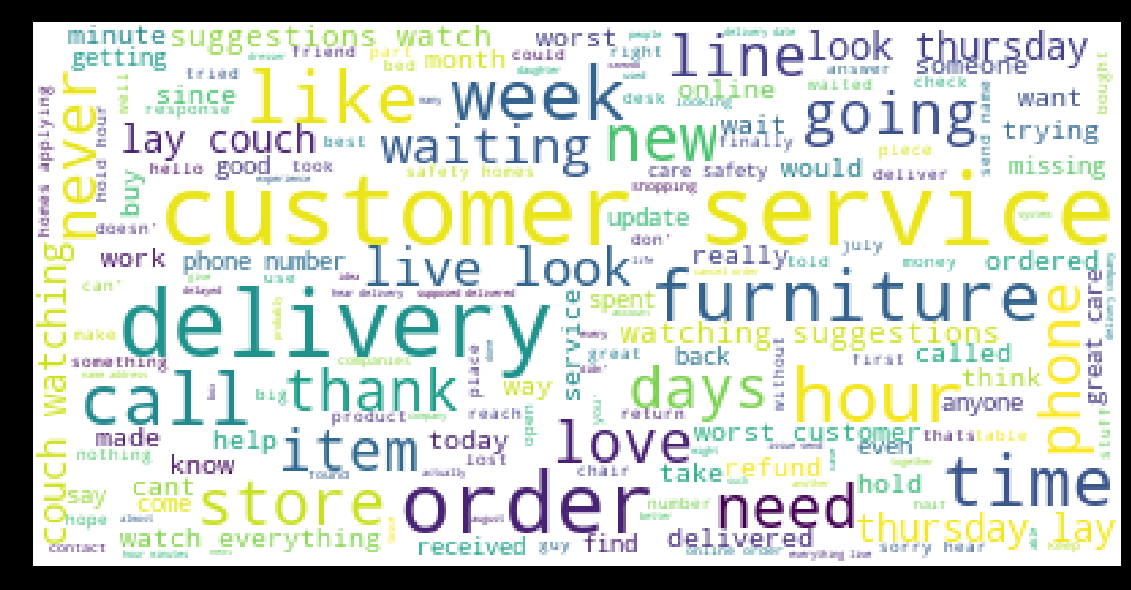

In [14]:
list1 = ['RT','rt','display_text_range','IKEAUSA','IKEA','USA','ikr', 'ikea', 'got','get','see','happened','also','much',
             'one','two','three','four', 'bangladeshi','amp', 'weve','ago','ive','appears','put','still','hey','ever','go',
             'please','arent', 'couldnt','didnt', 'doe', 'doesnt', 'dont', 'ha', 'hadnt', 'hasnt', 'havent', 'ikeausa', 'isnt',
             'mightnt', 'mustnt', 'neednt', 'shant','shes', 'shouldnt', 'shouldve', 'thatll', 'usa', 'wa', 'wasnt', 'werent',
             'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve','haveshe','happening','world', 'tryna', 'helprt', 'linemy',
             'homo','noticia','viking','word','nodtheres','hbolingbrook','happensthank', 'wk', 'threei', 'mycelium', 'herean',
             'head','writingyep','tweet','throuour','myou','homeare','hex', 'houshowed','relatively','96', 'nyrt','tienda',
             'wathats', 'optionrt', 'helpmy', 'nyrt','u','2','day','uhow','napour','honow', 'conshoho']
stop_list = stopwords.words('english') + list1+ list(punctuation)

from wordcloud import WordCloud
def wordcloud(tweets,col):
    stop_words=stop_list
    wordcloud = WordCloud(background_color="white",stopwords=stop_list,random_state = 0).generate(" ".join([i for i in tweets[col]]))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("IKEA USA Tweets")
wordcloud(data,'text')  

## Sentiment analysis
In this part, I am going to do a sentiment analysis. Three categories will be distinguished based on their polarity score: the positive tweets, the neutral tweets, and the negative tweets.

In [15]:
#data['text_lem'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in data['text']]       
vectorizer = TfidfVectorizer(max_df=0.5,max_features=10000,min_df=10,stop_words=stop_list,use_idf=True)
X = vectorizer.fit_transform(data['text'].str.upper())
sid = SentimentIntensityAnalyzer()
data['sentiment_compound_polarity']=data.text.apply(lambda x:sid.polarity_scores(x)['compound'])
data['sentiment_neutral']=data.text.apply(lambda x:sid.polarity_scores(x)['neu'])
data['sentiment_negative']=data.text.apply(lambda x:sid.polarity_scores(x)['neg'])
data['sentiment_pos']=data.text.apply(lambda x:sid.polarity_scores(x)['pos'])
data['sentiment_type']=''
data.loc[data.sentiment_compound_polarity>0,'sentiment_type']='Positive'
data.loc[data.sentiment_compound_polarity==0,'sentiment_type']='Neutral'
data.loc[data.sentiment_compound_polarity<0,'sentiment_type']='Negative'

In [16]:
data.tail()

,text,tokens,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
1733,hey don' hate ikea used,"[hate, use]",-0.5719,0.519,0.481,0.0,Negative
1734,rumor one was able figure out the ikea direction,"[rumor, able, figure, direction]",0.0000,1.000,0.000,0.0,Neutral
1735,ikea swedish for worst customer service you will ever experience your entire life,"[swedish, worst, customer, service, experience, entire, life]",-0.6249,0.745,0.255,0.0,Negative
1736,what about,[],0.0000,1.000,0.000,0.0,Neutral
1737,what about the salmon and all the chocolate,"[salmon, chocolate]",0.0000,1.000,0.000,0.0,Neutral


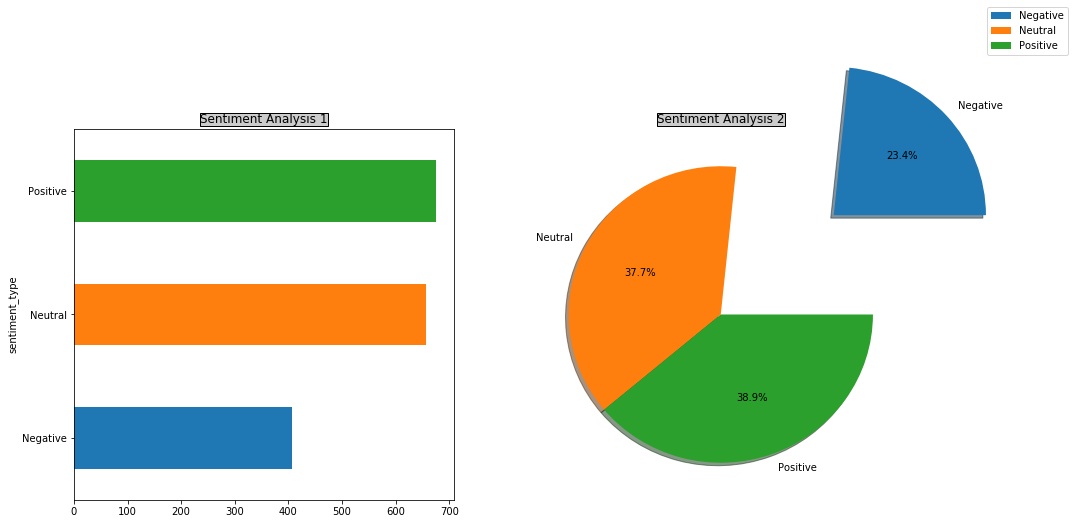

In [17]:
tweets_sentiment = data.groupby(['sentiment_type'])['sentiment_neutral'].count()
tweets_sentiment.rename("",inplace=True)
explode = (1, 0, 0)
plt.subplot(221)
tweets_sentiment.transpose().plot(kind='barh',figsize=(15, 15))
plt.title('Sentiment Analysis 1', bbox={'facecolor':'0.8', 'pad':0})
plt.subplot(222)
tweets_sentiment.plot(kind='pie',figsize=(15, 15),autopct='%1.1f%%',shadow=True,explode=explode)
plt.legend(bbox_to_anchor=(1.2, 1.2), loc=3, borderaxespad=0.)
plt.title('Sentiment Analysis 2', bbox={'facecolor':'0.8', 'pad':0})
plt.show()

In [18]:
data['str_tokens']= data['tokens'].apply(', '.join)

In [19]:
data.head()

,text,tokens,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type,str_tokens
0,mini date day with boo tampa,"[mini, date, boo, tampa]",0.0000,1.000,0.000,0.0,Neutral,"mini, date, boo, tampa"
1,applewatch suggestion for new workout option constructing furniture need nap,"[applewatch, suggestion, new, workout, option, construct, furniture, need, nap]",0.0000,1.000,0.000,0.0,Neutral,"applewatch, suggestion, new, workout, option, construct, furniture, need, nap"
2,our first date night since moving nyc and youve ruined was going come home comfy couch and,"[first, date, night, since, move, nyc, ruin, go, come, home, comfy, couch]",-0.4767,0.838,0.162,0.0,Negative,"first, date, night, since, move, nyc, ruin, go, come, home, comfy, couch"
3,reasons done with their product had defect but they wouldnt ship new piece had,"[reason, do, product, defect, ship, new, piece]",-0.1779,0.884,0.116,0.0,Negative,"reason, do, product, defect, ship, new, piece"
4,you are the worst how are you guys still business,"[worst, guy, business]",-0.6249,0.687,0.313,0.0,Negative,"worst, guy, business"


# Model

In [20]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 20

## a) Bag of Words (BoW):
### Term Frequency Vectorizor 

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer()
tf = tf_vectorizer.fit_transform(data['str_tokens'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [22]:
# print(tf_vectorizer.vocabulary_)

### Latent Dirichlet Allocation (LDA)

In [23]:
from sklearn.decomposition import LatentDirichletAllocation
no_topics=3
lda_tf = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [24]:
display_topics(lda_tf, tf_feature_names, no_top_words)

Topic 0:
love new go que crayfish furniture hello time report think weekend party look years come pop desk head free walk
Topic 1:
make help use like long store weeks never today last take refund buy great things someone would bed show open
Topic 2:
order delivery customer service call watch phone hold look time wait email deliver worst couch live try everything minutes furniture


### Visualising the model

In [25]:
def prep_corpus(docs, no_below=5, no_above=0.5):
  dictionary = Dictionary(docs)
  dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
  dictionary.compactify()
  corpus = [dictionary.doc2bow(doc) for doc in docs]

  return dictionary, corpus

In [26]:
dictionary, corpus = prep_corpus(data['tokens'])

In [27]:
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, passes=10)

In [28]:
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

C:\Users\Shahin\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


## b) Tfidf Vectorizer 

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(data['str_tokens'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

### Non-Negative Matrix Factorization (NMF)

#### LDA can only use raw term counts for LDA because it is a probabilistic graphical model. However, NMF is able to use tf-idf as it is based on linear algebra.

In [30]:
from sklearn.decomposition import NMF

In [31]:
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

In [32]:
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
watch suggestions lay look thursday everything live couch solve tip snap space college click purpose saver multi apartment small like
Topic 1:
service customer order call delivery phone worst wait deliver try number time hold work email online tell line hours minutes
Topic 2:
great apply safety care home office welcome newly makeover organize space hear spend forward explore look hours stay belly take


## Conclusion

The result of sentiment analysis shows that about 23% of the data are negative comments. This portion of the data should be the focus of further analysis in order to increase customer satisfaction. Topic modeling indicates that in general the tweets addressing IKEA USA can be clustered into 3 topics:

1. Customers who are happy with Products, Design, Pricing and Food at the restaurant. 
2. Customers who are complaining about Delivery Service.
3. Customers who are not satisfied with Customer Service on Phone and On-line.

The above mentioned topics suggest that better supervision needed on delivery companies working with IKEA as contractors. However, the cost of delivery seems to be reasonable compared to the competitors, delays and failing to deliver on the promised date seem to be a major problem. 

In terms of customer service, the complaints are mainly around extensive times being on hold, not receiving any satisfactory response, or refund. Having enough knowledgeable staff to answer the phone calls with authority to come up with right solutions for the customers could help in this respect. Also, a data analyst is needed in every store or cluster of stores to analyze the data coming from Twitter, Face book, or other Social Medias and via emails. This person needs to provide the managers of the departments with the insight on complaints concerning their departments.


## Disclaimer

This is a simple, basic analysis, based on few numbers of tweets addressing IKEA USA for the purpose of learning and practicing topic modeling.  Therefore, the result could be very biased and not accurate at all. It has been done only as an example to see what can be done with twitter data addressing a business. In order to conduct a concrete analysis, many more data from twitter as well as finer methods of analysis are needed. 